# Motorica Internship, Sprint 3

## ENC Model 

The aim is to develop a NN model to predict the values of the ENC0..ENC4 signals of glove encoders. These signals represent measurements of the straightening or contracting of the pilot's fingers.  The idea is to build the NN model without regard to the pilot's hand pronation.

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# uncomment for interactive graph
# %matplotlib widget

# IO utils


In [23]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [24]:
palm_file = "./Data/sprint3_pilote1_mount1_gestures.palm"  
MODEL_FN = './Models/ENC_model102_10.hdf5'
N_UNITS = 32 # Number of Units in RNN 
#  If there will be N units in RNN, than 
slice_step = round(N_UNITS/8)   #Not more than N/2
slice_len = N_UNITS*2   #Not less than N * 2
NUM_EPOCH = 250
CORR_HURDLE = 0.02  #Level of Correlation to pass channel for usage
TRAIN_PART = 0.8 
VALIDATION_PART = 0.15   #Validation during NN training
gestures_train = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print("Observations shape:", gestures_train.shape)
train_size = round(gestures_train.shape[0]*TRAIN_PART)
print("Train size", train_size, "Test size",gestures_train.shape[0]-train_size)
gestures_train.head()

Observations shape: (19569, 65)
Train size 15655 Test size 3914


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,6,0,7,0,0,12,0,13,20,0,...,57,6,22,27,19,0,0,0,34,980322
1,6,4,1,5,9,2,10,2,13,6,...,28,6,22,27,19,0,0,0,34,980355
2,9,0,4,15,2,8,22,9,10,14,...,7,6,22,27,19,0,0,0,34,980388
3,33,6,16,3,13,6,6,16,18,0,...,-1,6,22,27,19,0,0,0,34,980421
4,0,0,5,6,11,2,8,2,4,12,...,-2,6,22,27,19,0,0,0,34,980454


In [25]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [26]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4'] #ENC5 is empty
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']  #ENC5 is empty
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
FINGERS = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")
print("Fingers:", FINGERS)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
Fingers: ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']


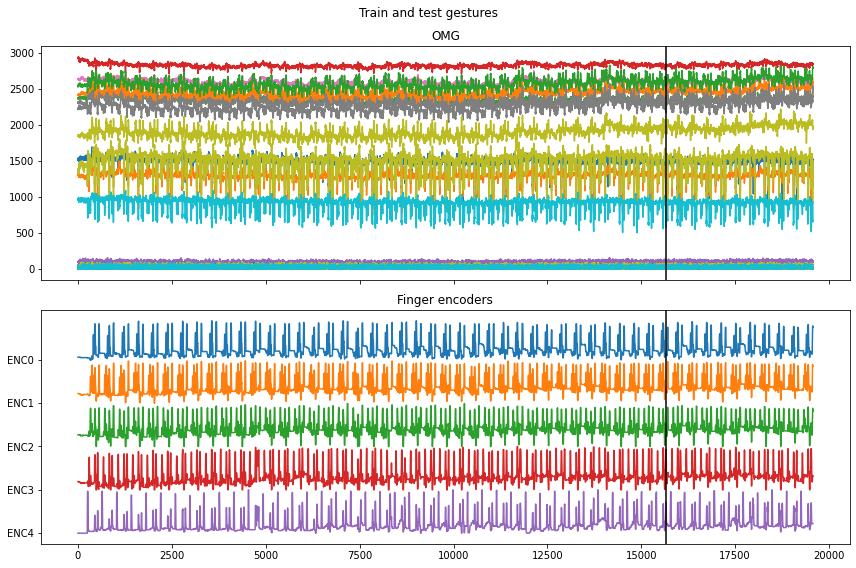

In [27]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
xax = np.arange(gestures_train.shape[0])
plt.sca(axx[0])
plot_train = plt.plot(xax, gestures_train[OMG_CH].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.title('OMG')
#plt.legend()

plt.sca(axx[1])
plot_train = plt.plot(xax, gestures_train[ENC_CH].values - np.arange(len(ENC_CH)) * 100)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.yticks(-np.arange(len(ENC_CH)) * 100, ENC_CH)
#plt.legend()
plt.title('Finger encoders')
#plt.xlabel('Timesteps')

#plt.sca(axx[2])
#plot_train = plt.plot(xax, gestures_train[ACC_CH].values - np.arange(len(ACC_CH)) * 200)
#plt.axvline(train_size, color='k', label='Train-Test split')
#plt.yticks(-np.arange(len(ACC_CH)) * 200, ACC_CH)
#plt.legend()
#plt.title('Accelerometer axes')
#plt.xlabel('Timesteps')


plt.suptitle('Train and test gestures')
plt.tight_layout()

# Preprocessing

In [28]:

train_data = gestures_train
high_ch = []
#for ch in OMG_CH:
#    if train_data[ch].min() > 200: high_ch.append(ch)
#assert len(high_ch) == 16
# Альтернативный способ определения занчимых каналов по корреляции
all_data = dict()
for t in ENC_CH:
    targ=dict()
    for i in OMG_CH: 
        c = round(abs(gestures_train[t].corr(gestures_train[i])),3)
        targ[i] = c
    all_data[t] = {k: v for k, v in sorted(targ.items(), key=lambda item: item[1], reverse=True)}
for t in ENC_CH:
    high_ch += [k for k,v in all_data['ENC4'].items() if v >= CORR_HURDLE]
high_ch = sorted(list(set(high_ch)))    
print("High OMG channels:", high_ch, "total q-ty", len(high_ch))


High OMG channels: ['12', '13', '14', '16', '17', '20', '21', '22', '23', '27', '28', '29', '30', '31', '32', '37', '38', '39', '48'] total q-ty 19


In [29]:
omg_num = [int(x) for x in OMG_CH]
high_ch_num = [int(x) for x in high_ch]
#print(high_ch_num)
ch_to_delete = [x for x in omg_num if x not in high_ch_num]
print("Channels to delete", ch_to_delete)

Channels to delete [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 18, 19, 24, 25, 26, 33, 34, 35, 36, 40, 41, 42, 43, 44, 45, 46, 47, 49]


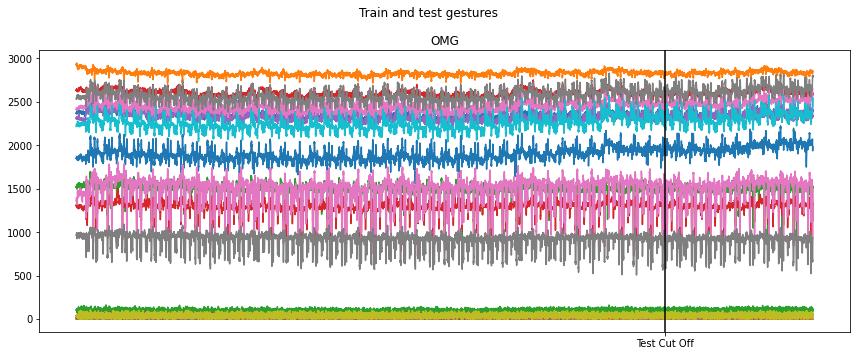

In [30]:
fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 5))
xax = np.arange(train_data.shape[0])
#plt.sca(axx[0])
plot_train = plt.plot(xax, train_data[high_ch].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
plt.axvline(train_size, color='k', label='Train-Test split')
plt.xticks( ticks=[train_size], labels=["Test Cut Off"])
plt.title('OMG')
plt.suptitle('Train and test gestures')
plt.tight_layout()

Идея новой модели - сделать обучение на основе входных данных, которые объединяют текущее значение значений датчиков и предыдущее значение координат перчатки.  Это некоторый прокси-вариант авторегрессионного обучения. 

The idea of the new model is to do training based on input data that combines the current value of the sensor values and the previous value of the glove coordinates.  This is some proxy version of autoregressive training. 

Подача выходного сигнала на вход называется обратной связью.  Может быть много различных вариантов обратной связи, например: 
- задержанное значение выхода,
- результат дифференцирования выхода,
- результат интегрирования выхода.

Интегрирование выглядит наиболее сложно для реализации.  Однако для обратной связи может быть достаточно не полного интеграла от начала работы. Один из вариантов интегрирования выхода - использование модели Хольта-Винтерса с альфа из [0.33, 0.2, 0.1, 0.05]. 

Подача обработанного выходного сигнала на вход вероятно будет препятствовать вырождению модели. 

Feeding the output signal to the input is called feedback.  There can be many different types of feedback, e.g: 
- delayed output value,
- the result of differentiating the output,
- The result of integrating the output.

Integration looks the most difficult to implement.  However, for feedback it may not be sufficient to have a full integral from the start. One option for integrating the output is to use a Holt-Winters model with alpha from [0.33, 0.2, 0.1, 0.05]. 

Feeding the processed output signal back to the input is likely to prevent degeneration of the model. 

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# file paths for sliced data
train_path  = "./Data/ENC_Train.npy"
target_path = "./Data/ENC_Target.npy"
test_path   = "./Data/ENC_Test.npy"
true_path = "./Data/ENC_True.npy"
orig_path = "./Data/ENC_Orig.npy"



# Min Max Scalling of selected OMG channels and saving results
X_orig_train = scaler.fit_transform(train_data[high_ch].values)
np.save(orig_path, X_orig_train)


In [32]:
# Making feedback from Target
new_col_names = {'ENC0':'fbENC0', 'ENC1':'fbENC1', 'ENC2':'fbENC2', 'ENC3':'fbENC3', 'ENC4':'fbENC4'}
#orig_Y = train_data[ENC_CH]
#orig_Y.head()
feedback_Y = train_data[ENC_CH].diff()
feedback_Y.rename(columns=new_col_names, inplace=True)
feedback_Y.fillna(0, inplace=True)
feedback_Y = feedback_Y.shift(periods=1, fill_value=0)
#feedback_Y.head()
for c in feedback_Y.columns:
    print(c, feedback_Y[c].min(), feedback_Y[c].max())

fbENC0 -33.0 26.0
fbENC1 -30.0 22.0
fbENC2 -27.0 23.0
fbENC3 -30.0 39.0
fbENC4 -23.0 31.0


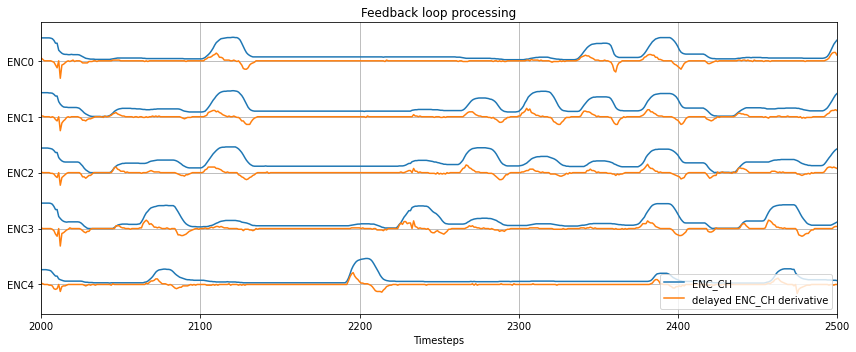

In [90]:
xmin, xmax = 2000, 2500
MULT_FACTOR = 2.5                # Acceleraton of Y

fig = plt.figure(figsize=(12, 5))

lines = []
labels = []

plots = plt.plot(train_data[ENC_CH].values - np.arange(len(ENC_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['ENC_CH']

plots = plt.plot(feedback_Y * MULT_FACTOR - np.arange(len(ENC_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['delayed ENC_CH derivative']

plt.title('Feedback loop processing')
plt.yticks(-np.arange(len(ENC_CH)) * 200, ENC_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')
plt.xlim(xmin,xmax)

plt.tight_layout()

In [65]:
feedback_scaller= MinMaxScaler((0,1))
add_X=feedback_scaller.fit_transform(feedback_Y.values)

#feedback_Y = train_data[ENC_CH].shift(periods=1, fill_value=0)
#delayed_Y.head()

#delayed_Y.head()
#add_X = feedback_Y.values/100  # Scaling to 0..1 range
new_X = np.concatenate((X_orig_train,add_X), axis=1)
print(X_orig_train.shape, feedback_Y.shape, new_X.shape)

(19569, 19) (19569, 5) (19569, 24)


In [35]:


X_train = new_X[:train_size,:]
Y_train = train_data[ENC_CH].values[:train_size,:]
X_test = new_X[train_size:,:]
print("Test Shape:", X_test.shape)
Y_test = train_data[ENC_CH].values[train_size:,:]
print("(Ground)Truth Shape:",Y_test.shape)

#Slicing train data
x_start = 0
x_max = X_train.shape[0] - slice_len
train = list()
target = list()
while x_start <= x_max:
    r = x_start+slice_len
    train.append(X_train[x_start:r,:])
    target.append(Y_train[x_start:r,:])
    x_start += slice_step
# converting lists to np arrays
prep_train = np.stack(train,axis=0)
print("Train Shape",prep_train.shape)
prep_targ = np.stack(target,axis=0)
print("Target Shape",prep_targ.shape)
# saving prepared data
np.save(train_path,prep_train)
np.save(target_path,prep_targ)
np.save(test_path, X_test)
np.save(true_path,Y_test)


Test Shape: (3914, 24)
(Ground)Truth Shape: (3914, 5)
Train Shape (3898, 64, 24)
Target Shape (3898, 64, 5)


In [36]:
train = np.load(train_path)
target = np.load(target_path)
test = np.load(test_path)
truth = np.load(true_path)
N_OMG = train.shape[2]
N_OUT = target.shape[2]

# Modeling

## Model planning

In [37]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

CH = ['ENC0','ENC1', 'ENC2', 'ENC3', 'ENC4']


RANDOM_SEED = 19

2023-06-08 08:07:27.245389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
#print(f"input_shape = {(n_ts, n_chan)} | output_units = {out_units}")  #n_ts
input_channels = x = tf.keras.layers.Input(shape=(None, N_OMG)) #n_ts
x = tf.keras.layers.GRU( units=N_UNITS, activation='relu', return_sequences=True, 
                              recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2), )(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=30, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5)))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)


output = tf.keras.layers.Dense(units=N_OUT, activation='relu', bias_regularizer=tf.keras.regularizers.l2(1e-4), activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)

model_struct = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="ENC_Model"
)

model_struct.summary()

Model: "ENC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 24)]        0         
                                                                 
 gru (GRU)                   (None, None, 32)          5568      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 time_distributed (TimeDistr  (None, None, 30)         990       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 30)         120       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, None, 30)          0 

In [39]:
save_best = tf.keras.callbacks.ModelCheckpoint(MODEL_FN, monitor='val_mse', verbose=0, mode='min', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_mse', patience=50, restore_best_weights=True) 
callbacks=[save_best, early_stopping]

## Model Training

Val Loss 31.7 Val MSE 25.9


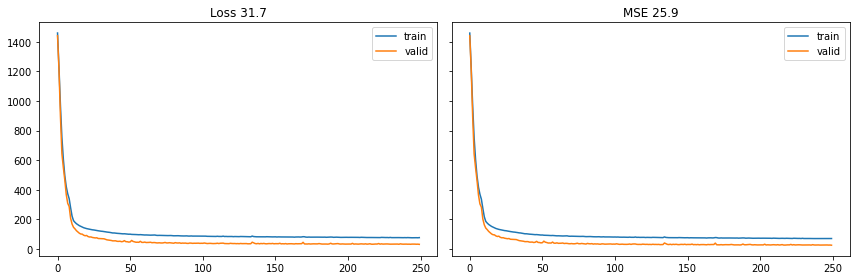

In [40]:
X_trn, X_val, Y_trn, Y_val = train_test_split(train, target, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)
model = tf.keras.models.clone_model(model_struct)
model.compile( loss= 'mse', metrics= ['mse'], optimizer=tf.keras.optimizers.Adam(), )
hist = model.fit( X_trn, Y_trn, epochs=NUM_EPOCH, verbose=0, validation_data= (X_val, Y_val), callbacks= callbacks) 
h = hist.history
model.load_weights(MODEL_FN)
vloss = str(round(np.min(h['val_loss']),1))
vmse = str(round(np.min(h['val_mse']),1))
print("Val Loss",vloss, "Val MSE", vmse )

#vloss = str(round(np.min(h['val_loss']),1))
#vmse = str(round(np.min(h['val_mse']),1))
fig, axx = plt.subplots(1,2, figsize=(12,4),sharey=True)
axx[0].plot(h['loss'], label='train')
axx[0].plot(h['val_loss'], label = 'valid')
axx[0].set_title('Loss '+vloss)
axx[0].legend(loc='best')
axx[1].plot(h['mse'], label = 'train')
axx[1].plot(h['val_mse'], label = 'valid')
axx[1].set_title('MSE '+vmse)
axx[1].legend(loc='best')
plt.tight_layout()
plt.show();
    


## Prediction and Metrics

In [41]:
#Predict Test data
x_test = np.expand_dims(test, axis=0)
y_pred = np.reshape(model.predict(x_test, verbose=0),(-1,N_OUT))
print("Test MSE")
for i in range(len(CH)):
    print(CH[i], round(mean_squared_error(truth[:,i],y_pred[:,i]),2))
print("Average", round(mean_squared_error(truth, y_pred),2) )

Test MSE
ENC0 32.48
ENC1 31.33
ENC2 28.38
ENC3 49.56
ENC4 35.49
Average 35.45


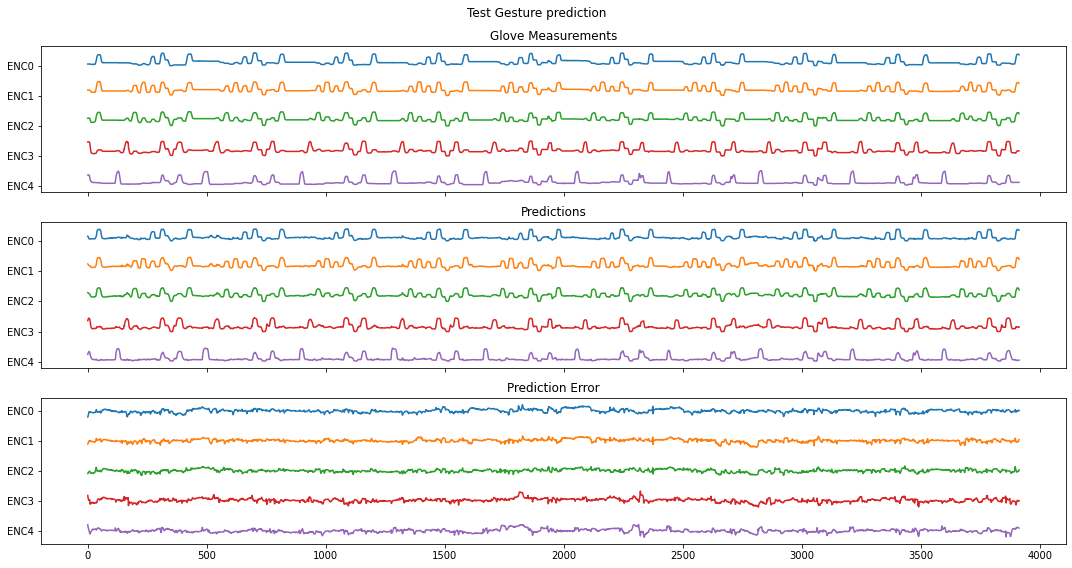

In [42]:
x_axis = np.arange(truth.shape[0])
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(15, 8))
plt.sca(axx[0])
plt.plot(x_axis, truth - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Glove Measurements')
plt.sca(axx[1])
plt.plot(x_axis, y_pred - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Predictions')
plt.sca(axx[2])
plt.plot(x_axis, truth-y_pred - np.arange(len(CH)) * 100)
plt.yticks(-np.arange(len(CH)) * 100, CH)
#plt.legend()
plt.title('Prediction Error')
plt.suptitle('Test Gesture prediction')
plt.tight_layout()


In [43]:
# assert False

## Duplicating Model for Serial Inference

In [44]:
model.summary()

Model: "ENC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 24)]        0         
                                                                 
 gru (GRU)                   (None, None, 32)          5568      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 time_distributed (TimeDistr  (None, None, 30)         990       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 30)         120       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, None, 30)          0 

In [45]:
model_input = tf.keras.Input(batch_shape=(1, 1, N_OMG))
x = tf.keras.layers.GRU( units=N_UNITS, activation='relu', return_sequences=True, stateful=True, unroll=True )(model_input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=30, activation='relu'))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
model_output = tf.keras.layers.Dense(N_OUT, activation='relu')(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='ENC_model_stateful'
)

model_stateful.set_weights(model.get_weights())
print(model_stateful.summary())


Model: "ENC_model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 24)]              0         
                                                                 
 gru_1 (GRU)                 (1, 1, 32)                5568      
                                                                 
 dropout_2 (Dropout)         (1, 1, 32)                0         
                                                                 
 time_distributed_1 (TimeDis  (1, 1, 30)               990       
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (1, 1, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (1, 1, 30)         

## Verifying Serial Statefull Model

In [46]:
import time

In [47]:
%%time
model_stateful.reset_states()
y_pred_statefull = list()
n_iter = x_test.shape[1]
start_time = time.time()
for i in range(n_iter):
    x = x_test[0,i,:].reshape((1,1,-1))
    y = model_stateful(x,training=False).numpy()
    y_pred_statefull.append(y)
end_time = time.time()
av_duration = (end_time - start_time)/n_iter * 1000  #convert to mSec 
y_pred_statefull = np.hstack(y_pred_statefull).reshape((-1,N_OUT))
print("Statefull prediction Shape:", y_pred_statefull.shape)
print(f"Avg time of {n_iter} iters: {av_duration:.2f} mSec")



Statefull prediction Shape: (3914, 5)
Avg time of 3914 iters: 8.08 mSec
CPU times: user 31.5 s, sys: 83.9 ms, total: 31.6 s
Wall time: 31.6 s


In [48]:
# CHECK equality of predictions
print("Two predictions are close:", np.allclose( y_pred[:,0], y_pred_statefull[:,0], atol=0.001))
print("MSE of predictions", mean_squared_error(y_pred,y_pred_statefull))


Two predictions are close: True
MSE of predictions 1.7161486e-11


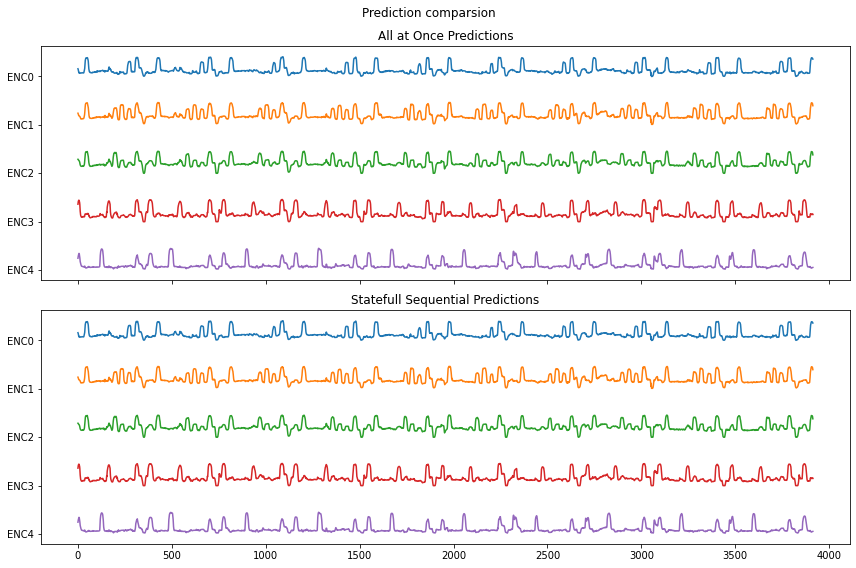

In [49]:
x_axis = np.arange(truth.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
plt.sca(axx[0])
plt.plot(x_axis, y_pred - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('All at Once Predictions')
plt.sca(axx[1])
plt.plot(x_axis, y_pred_statefull - np.arange(len(CH)) * 200)
plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
plt.title('Statefull Sequential Predictions')
plt.suptitle('Prediction comparsion')
plt.tight_layout()

In [50]:
# Comment if you do not want to stop here! 
# assert False

# Real-time inference

In [51]:
import time
from IPython.display import clear_output

In [52]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [75]:
def preprocessing(x,dy1, dy2):
    # x - sample vector
    x = np.delete(x,ch_to_delete)
    sx = scaler.transform(x.reshape(1,-1)).flatten()
    fby = dy1-dy2
    dy = feedback_scaller.transform(fby.reshape(1,-1)).flatten()
    #dy = dy/100
    #print(sx.shape, dy.shape)
    y = np.concatenate((sx,dy))

    return y

def inference(x):
    y = model_stateful(x.reshape((1,1,-1)),training=False).numpy().flatten()
    return y

def postprocessing(x, prev):
    if prev is None:  
        prev = x.copy()
    
    y = x*0.2 + prev*0.8 # Holt-Winters filter
    return y

def commands(x):
    y = np.clip(x, 0, 100).astype(int) #np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [91]:
def plot_output(df_sim, y_dct, xmin, xmax):
    fig = plt.figure(figsize=(13, 7))

    lines = []
    labels = []

    plots = plt.plot(df_sim[ENC_CH].values - np.arange(len(ENC_CH)) * 200, c='C0')
    lines += [plots[0]]
    labels += ['ENC_CH']

    plots = plt.plot(y_dct['y_predicted'] - np.arange(len(ENC_CH)) * 200, c='C1')
    lines += [plots[0]]
    labels += ['y_predicted']

    #plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(ENC_CH)) * 200, c='C2')
    #lines += [plots[0]]
    #labels += ['y_postprocessed']

    plots = plt.plot(y_dct['y_commands'] - np.arange(len(ENC_CH)) * 200, c='C3')
    lines += [plots[0]]
    labels += ['y_commands']

    plt.title('Ground truth vs prediction')
    plt.yticks(-np.arange(len(ENC_CH)) * 200, ENC_CH)
    plt.legend(lines, labels)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.xlim(xmin,xmax)

    plt.tight_layout()

In [55]:
df_sim = gestures_train.copy().iloc[:10000]
# df_sim = free_movements.iloc[:10000]
print("Simulation Data Shape", df_sim.shape)

Simulation Data Shape (10000, 65)


omg_sample.shape = (10000, 50)
enc_sample.shape = (10000, 6)
sample_preprocessed.shape = (10000, 24)
y_predicted.shape = (10000, 5)
y_postprocessed.shape = (10000, 5)
y_commands.shape = (10000, 5)
duration.shape = (10000,)
Average observation processing duration 8.69190855026245 mSec


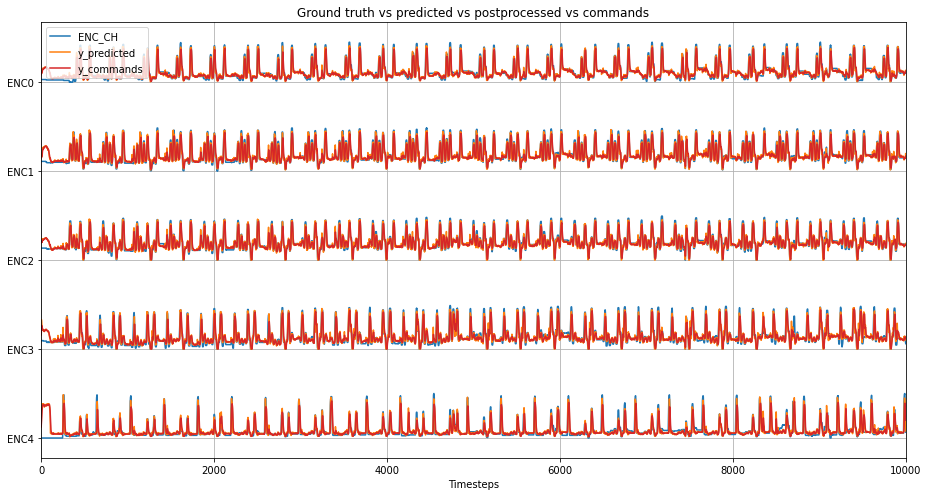

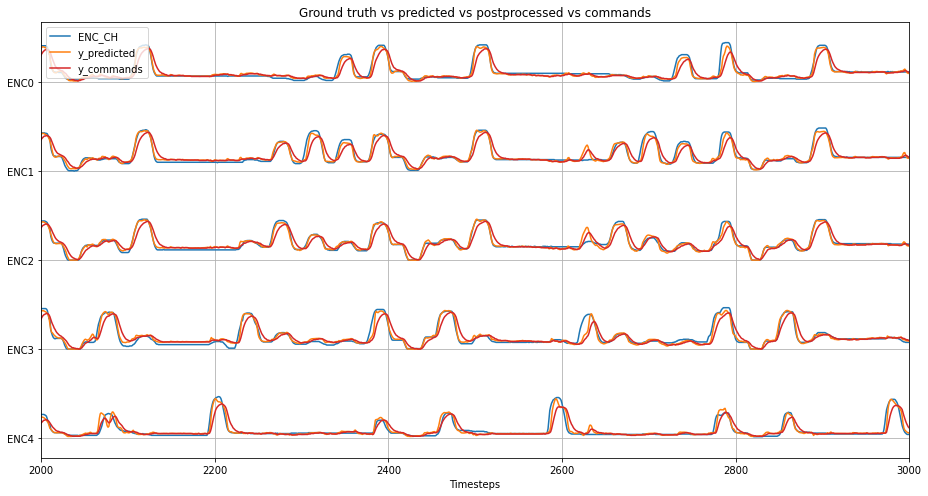

In [79]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0


model_stateful.reset_states()

y_previous = None
y_delayed2 = np.zeros(N_OUT) 
y_delayed1 = np.zeros(N_OUT) 

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'duration': [],
}

ts_old = time.time()
ts_diff = 0;

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, y_delayed1, y_delayed2)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    y_delayed2, y_delayed1 = y_delayed1, y_predicted                                #feed prediction to input
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    y_dct['duration'].append(ts_diff*1000)
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 



for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

print("Average observation processing duration", y_dct['duration'].mean(),"mSec")

plot_output(df_sim, y_dct, 0, df_sim.shape[0]) 
plot_output(df_sim, y_dct, 2000, 3000) 



In [89]:
print("Offline Statefull Inference MSE")
for i in range(len(CH)):
    sim_truth = df_sim[ENC_CH].values
    pred_mse = round(mean_squared_error(sim_truth[:,i],y_dct['y_predicted'][:,i]),2)
    cmd_mse = round(mean_squared_error(sim_truth[:,i],y_dct['y_commands'][:,i]),2)
    print(f"Channel {CH[i]} prediction error {pred_mse}, final error {cmd_mse}" )
av_pred_mse = round(mean_squared_error(sim_truth,y_dct['y_predicted']),2)
av_cmd_mse = round(mean_squared_error(sim_truth,y_dct['y_commands']),2)

print(f"Average prediction error {av_pred_mse}, final error {av_cmd_mse} ") 

Offline Statefull Inference MSE
Channel ENC0 prediction error 30.87, final error 92.48
Channel ENC1 prediction error 38.15, final error 131.09
Channel ENC2 prediction error 27.84, final error 96.77
Channel ENC3 prediction error 67.79, final error 161.31
Channel ENC4 prediction error 123.03, final error 193.07
Average prediction error 57.54, final error 134.94 


In [82]:
df_sim['ENC0'].shape

(10000,)

In [84]:
y_dct['y_predicted'].shape

(10000, 5)

In [85]:
y_dct['y_commands'].shape

(10000, 5)

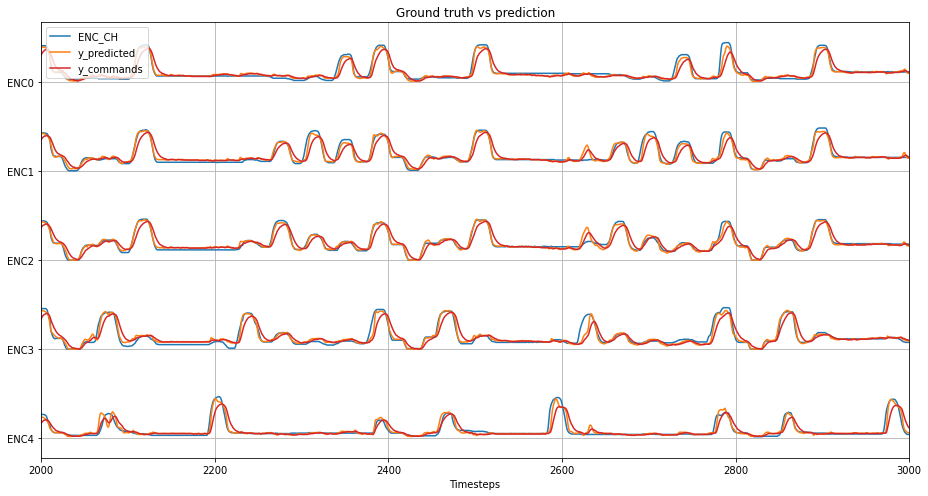

In [92]:
plot_output(df_sim, y_dct, 2000, 3000) 


### Online (prosthesis or virtual hand)

In [57]:
"""
# Uncomment to run

import serial

TIMEOUT = 0.033
DEBUG = True

model_stateful.reset_states()

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

"""

'\n# Uncomment to run\n\nimport serial\n\nTIMEOUT = 0.033\nDEBUG = True\n\nmodel_stateful.reset_states()\n\nser = None\n# ser_port = None\n# ser_port = \'/dev/ttyACM0\'\nser_port = \'/dev/cu.usbmodem3498365F31351\'\n\nif ser_port is not None:\n    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)\n    ser.write(\'T1#\r\n\'.encode(\'utf-8\')) # T1 for Timestamp activate\n    ser.write(\'M2#\r\n\'.encode(\'utf-8\')) # M2 for Mode == 2 = send samples\n    ser.write(\'S2#\r\n\'.encode(\'utf-8\')) # SYNC to 2 for sanity check\n\n    # flush buffers\n    ser.reset_input_buffer()\n    ser.read()\n    \n    i = 0;\n    while(ser.in_waiting):\n        print(f\'Flushing buffers {i}: {ser.in_waiting}\', end=\'    \r\')\n        ser.read_all()\n        time.sleep(0.005)\n        i+=1;\n    ser.readline()\n    ser.readline()\n    \ni = 0\nts_old = time.time()\nts_diff = 0;\n\ny_previous = None\nwhile True:    \n    \n    # [Data reading]\n    s = ser.readline()\n    ts_start = time.time()\n    